# Holiday Modeling Using Google Trends Data

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib

import cmdstanpy
cmdstanpy.install_cmdstan()
from cmdstanpy import CmdStanModel

from bayesian_holidays.src.fit_holiday_model import fit_holiday_model
from bayesian_holidays.src.plot_utils import (
    plot_posteriors,
    get_individual_holidays,
    plot_individual_holidays
)

CmdStan install directory: /Users/daniel.marthaler/.cmdstan
CmdStan version 2.34.1 already installed
Test model compilation


### Choose data and fit model

In [12]:
df_xmas, fit_xmas = fit_holiday_model(
    "ramadan",
    start_date=None,
    train_split=80,
    num_chains=4,
    max_treedepth=10,
    adapt_delta=0.8
)


14:01:15 - cmdstanpy - INFO - Chain [1] start processing
14:01:17 - cmdstanpy - INFO - Chain [1] done processing
14:01:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:04:07 - cmdstanpy - INFO - CmdStan done processing.
14:04:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[4] is 0, but must be positive finite! (in 'holiday_model.stan', line 175, column 4 to column 50)
Consider re-running with show_console=True if the above output is unclear!
14:04:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 46 divergent transitions (4.6%)
	Chain 2 had 44 divergent transitions (4.4%)
	Chain 3 had 31 divergent transitions (3.1%)
	Chain 3 had 899 iterations at max treedepth (89.9%)
	Chain 4 had 47 divergent transitions (4.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


### Plot posterior in hold out set

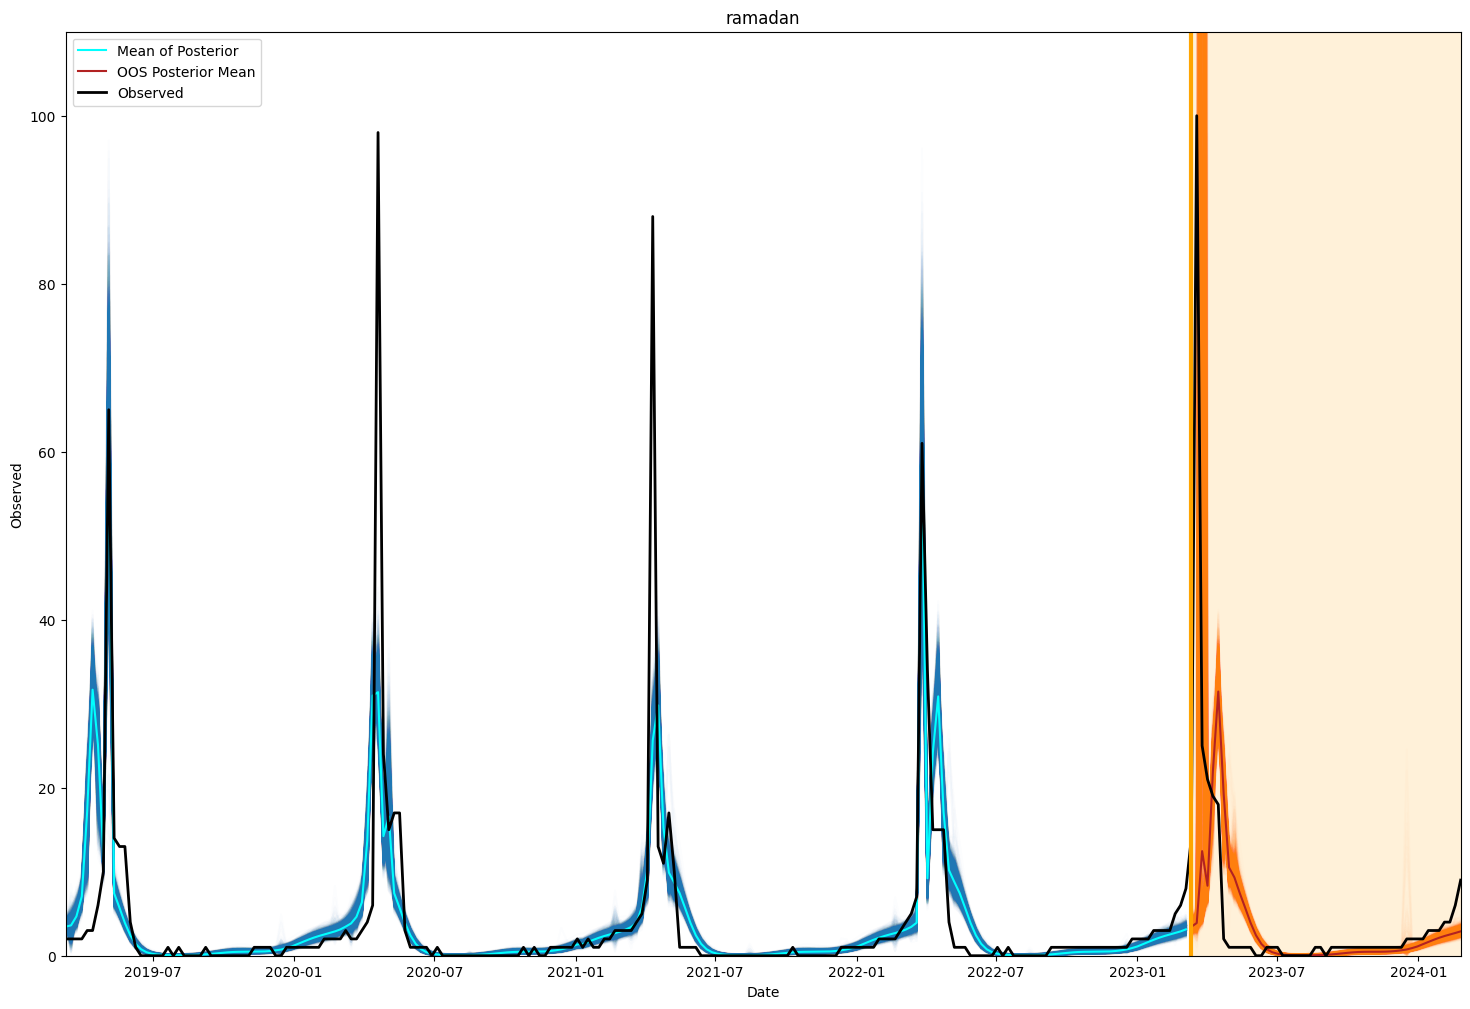

In [13]:
#plot_posteriors(df_xmas, fit_xmas, "chocolate")
plot_posteriors(df_xmas, fit_xmas, "ramadan")

### Plot Holiday Components for this search term

In [16]:
#holiday_list, hols_train, hols_test, df_train, df_test = get_individual_holidays(df_xmas, fit_xmas, country='UnitedStates')
holiday_list, hols_train, hols_test, df_train, df_test = get_individual_holidays(df_xmas, fit_xmas, country='Bangladesh')

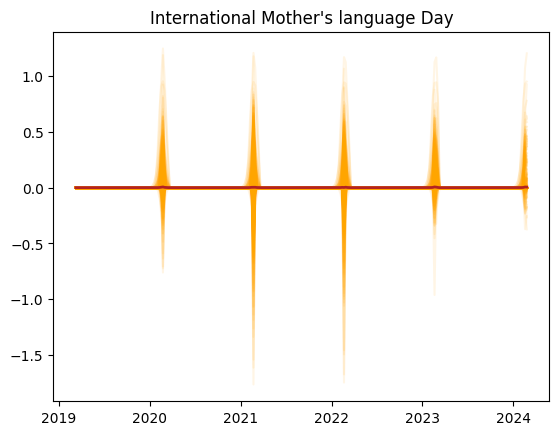

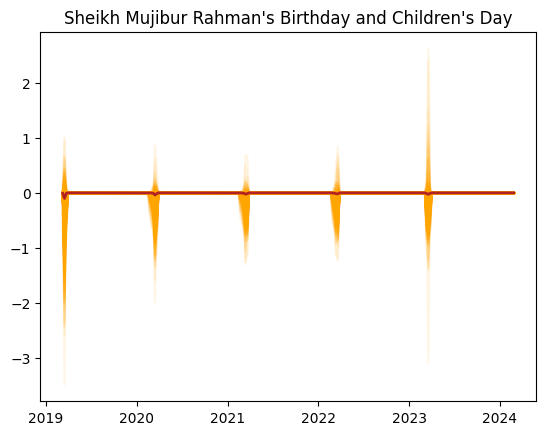

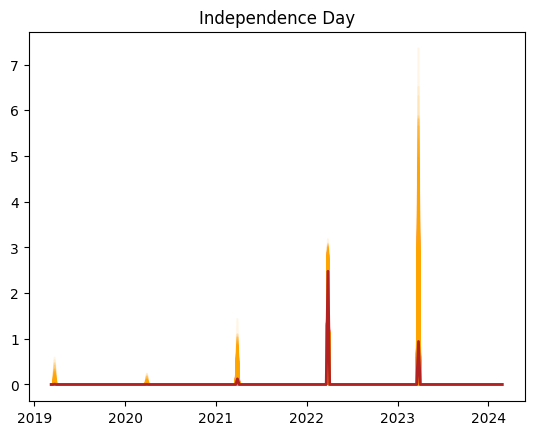

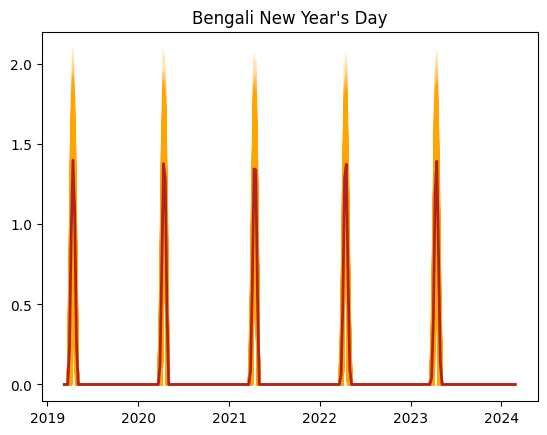

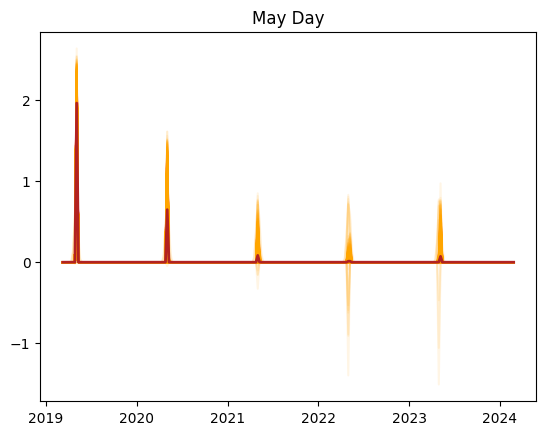

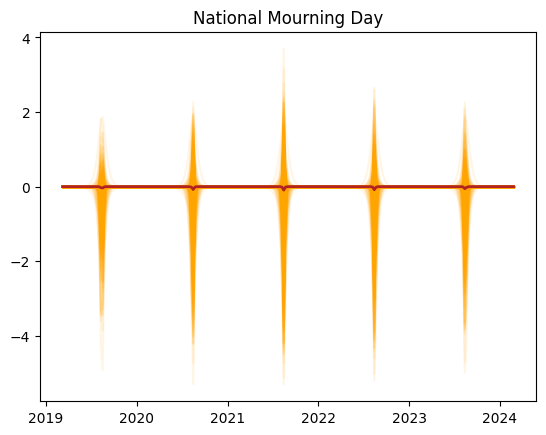

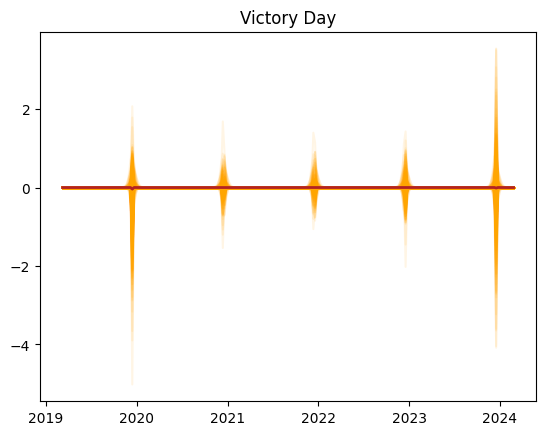

In [17]:
plot_individual_holidays(df_xmas.date,np.concatenate((hols_train, hols_test), axis=2), holiday_list.head(hols_test.shape[1]).HolidayName.values)